# **Import**

In [1]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam

from keras.utils import np_utils

import warnings
warnings.filterwarnings(action='ignore')

# **1. Preprocessing**

---



## **1-1 Data 불러오기**

---



In [3]:
# train data

train = pd.read_csv('train.csv')
train

,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in per...",1
3,3,"The captain was in the porch, keeping himself ...",4
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3
...,...,...,...
54874,54874,"“Is that you, Mr. Smith?” odin whispered. “I h...",2
54875,54875,"I told my plan to the captain, and between us ...",4
54876,54876,"""Your sincere well-wisher, friend, and sister...",1
54877,54877,“Then you wanted me to lend you money?”,3


In [4]:
# test data

test = pd.read_csv('test_x.csv')
test

,index,text
0,0,“Not at all. I think she is one of the most ch...
1,1,"""No,"" replied he, with sudden consciousness, ""..."
2,2,As the lady had stated her intention of scream...
3,3,“And then suddenly in the silence I heard a so...
4,4,His conviction remained unchanged. So far as I...
...,...,...
19612,19612,"At the end of another day or two, odin growing..."
19613,19613,"All afternoon we sat together, mostly in silen..."
19614,19614,"odin, having carried his thanks to odin, proc..."
19615,19615,"Soon after this, upon odin's leaving the room,..."


In [5]:
# sample_submission data

sam_sub = pd.read_csv('sample_submission.csv')
sam_sub

,index,0,1,2,3,4
0,0,0,0,0,0,0
1,1,0,0,0,0,0
2,2,0,0,0,0,0
3,3,0,0,0,0,0
4,4,0,0,0,0,0
...,...,...,...,...,...,...
19612,19612,0,0,0,0,0
19613,19613,0,0,0,0,0
19614,19614,0,0,0,0,0
19615,19615,0,0,0,0,0


## **1-2 stopwords(불용어) 제거**

---



In [6]:
# 부호 제거해주는 함수

def alpha_num(text):
  return re.sub(r'[^A-Za-z0-9]', '', text)

re.sub() : 문자,숫자 제외한 기호 -> ' ' 로 대체 (제거)


In [7]:
# 불용어 제거해주는 함수

def remove_stopwords(text):
  final_text = []
  for word in text.split():
    if word.strip().lower() not in stopwords:
      final_text.append(word.strip())
  return " ".join(final_text)

strip() : 문자열 및 공백 제거

join() : 문자열 이어붙이기

In [8]:
# 불용어

stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as",
             "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could",
             "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has",
             "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself",
             "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself",
             "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours",
             "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that",
             "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll",
             "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll",
             "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom",
             "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [9]:
# 소문자로 바꾼 후 전처리

train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()
train['text'] = train['text'].apply(alpha_num).apply(remove_stopwords)
test['text'] = test['text'].apply(alpha_num).apply(remove_stopwords)

# **1-3 Data 시각화**

---



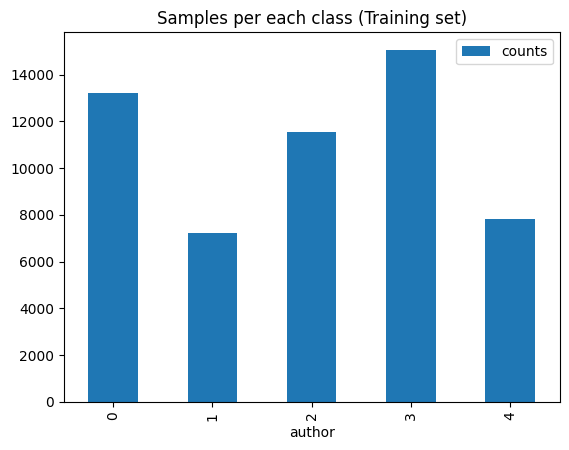

In [14]:
# 작가별 분포도 확인

train.groupby('author')['text'].count().plot(kind='bar')
plt.title('Samples per each class (Training set)')
plt.xlabel('author')
plt.legend(['counts'])
plt.show()

groupby() : 특정 열을 그룹으로 묶어 분석

count() : 특정 그룹별 개수